
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Read in Churn DS - Saved Locally to my PyCharm
# still looking into the certificate error

import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import OneHotEncoder
import seaborn as sns

df = pd.read_csv('../churn_ds.csv')

In [4]:
# function for turning TotalChares into Float values
def fix_float(cell):
  try: 
    return float(cell)
  except: 
    print(cell)
    return np.NaN

In [35]:
# Cleaning Wrangle function 

def wrangle(X):
    
    X = X.copy()
    
    # fixing column to change to float
    X['TotalCharges'] = X['TotalCharges'].apply(fix_float)
                                                  
    # replacing Yes/No with True/False
    columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']                                              
    for col in columns:
        X[col] = X[col].apply(lambda cell: cell.lower() == 'yes')

    y = X['Churn']    
        
    X.drop(['customerID', 'Churn'], axis=1, inplace=True)
                                                  
    return X, y   

In [37]:
X, y = wrangle(df)

In [38]:
print(X.shape)
print(y.shape)

(7043, 19)
(7043,)


In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5282, 19)
(5282,)
(1761, 19)
(1761,)


In [63]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Model Creation

In [42]:
# basic pipeline model
model = make_pipeline(
    OneHotEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender', 'MultipleLines',
                                     'InternetService', 'OnlineSecurity',
                                     'OnlineBackup', 'DeviceProtection',
                                     'TechSupport', 'StreamingTV',
                                     'StreamingMovies', 'Contract',
                                     'PaymentMethod'])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [43]:
# train accuracy - looks like I need to fix overfitting
model.score(X_train, y_train)

0.9979174555092768

In [44]:
# Val accuracy score - beats baseline guessing by about 5pts. I can get this much higher
model.score(X_val, y_val)

0.7847813742191937

# XGBoost

In [45]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=6)
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender', 'MultipleLines',
                                     'InternetService', 'OnlineSecurity',
                                     'OnlineBackup', 'DeviceProtection',
                                     'TechSupport', 'StreamingTV',
                                     'StreamingMovies', 'Contract',
                                     'PaymentMethod'])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='(

In [46]:
# Compare Train and Val Scores
print(pipeline.score(X_train, y_train))
print(pipeline.score(X_val, y_val))


0.9388489208633094
0.7864849517319704


In [47]:
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=6)
)

param_distributions= {
    'xgbclassifier__max_depth': range(4,6,1), 
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    verbose= 5, 
    return_train_score= True,

)
search.fit(X_train, y_train)
print(search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  xgbclassifier__max_depth=4, score=(train=0.890, test=0.785), total=   0.5s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  xgbclassifier__max_depth=4, score=(train=0.889, test=0.818), total=   0.6s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  xgbclassifier__max_depth=4, score=(train=0.887, test=0.794), total=   0.6s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s


[CV]  xgbclassifier__max_depth=4, score=(train=0.894, test=0.775), total=   0.6s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s


[CV]  xgbclassifier__max_depth=4, score=(train=0.890, test=0.793), total=   0.6s
[CV] xgbclassifier__max_depth=5 ......................................
[CV]  xgbclassifier__max_depth=5, score=(train=0.924, test=0.781), total=   0.6s
[CV] xgbclassifier__max_depth=5 ......................................
[CV]  xgbclassifier__max_depth=5, score=(train=0.917, test=0.790), total=   0.7s
[CV] xgbclassifier__max_depth=5 ......................................
[CV]  xgbclassifier__max_depth=5, score=(train=0.925, test=0.787), total=   0.6s
[CV] xgbclassifier__max_depth=5 ......................................
[CV]  xgbclassifier__max_depth=5, score=(train=0.923, test=0.773), total=   0.6s
[CV] xgbclassifier__max_depth=5 ......................................
[CV]  xgbclassifier__max_depth=5, score=(train=0.925, test=0.787), total=   0.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.8s finished


0.7928781069923454


In [48]:
best_pipe = search.best_estimator_
print('Validation Accuracy:', best_pipe.score(X_val, y_val))


Validation Accuracy: 0.7984099943214082


# Partial Dependence Plots

In [20]:
# include this note for later code processing
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [22]:
df.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [25]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [26]:

feature = 'tenure'

isolated = pdp_isolate(
    model=best_pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

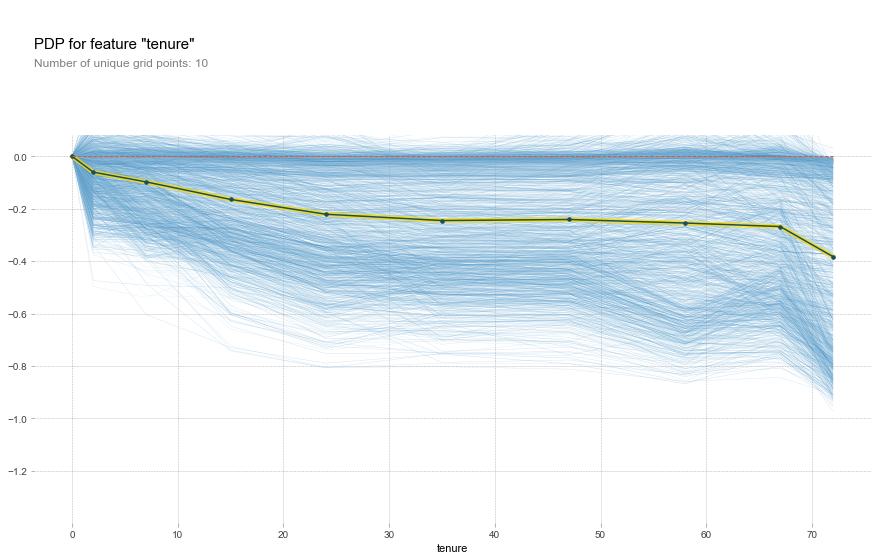

In [28]:
pdp_plot(isolated, feature_name=feature, plot_lines=True);

How Does this plot relate to the target on the y axis?
- When tenure increases, the chance of churn increases? Because if Churn = Yes, the person is more likely to leave. Because that is negative is that why the values are negative? 


In [29]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [52]:
features = ['tenure', 'MonthlyCharges']

interaction = pdp_interact(
    model=best_pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='t', ylabel='e'>})

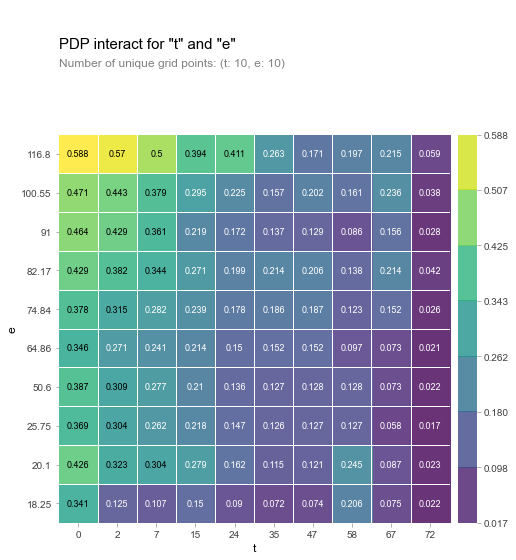

In [32]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=feature)

# Shapley Plot work

In [94]:
processor = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)

X_train_processed = processor.fit_transform(X_train)

In [95]:
X_val_processed = processor.transform(X_val)

In [96]:
eval_set = [(X_train_processed, y_train), 
           (X_val_processed, y_val)]

In [97]:
model= RandomForestClassifier(n_estimators=100, n_jobs=-1)

model.fit(X_train_processed, y_train)

RandomForestClassifier(n_jobs=-1)

In [98]:
from sklearn.metrics import roc_auc_score
class_index = 1
y_pred_proba = model.predict_proba(X_val_processed)[:, class_index]
print(f'Test ROC AUC Class {class_index}:')
print(roc_auc_score(y_val, y_pred_proba))

Test ROC AUC Class 1:
0.8219487736183142


In [110]:
row = X_val_processed[1000]
row

array([2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 5.6000e+01,
       1.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 7.5850e+01, 4.2612e+03])

In [126]:
row1 = X_val.iloc[[1000]]

In [87]:
from shap import TreeExplainer, GradientExplainer, 

In [100]:
explainer = TreeExplainer(model)

In [111]:
shap_values = explainer.shap_values(row)

In [127]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row1, 
    link='logit', 
)